# Week 2 - Sensitivity Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pulp import *

from scipy.optimize import linprog

## Product Mix Problem
###  Problem formulation
$\text{Decision variables}$
$x_1$ = # of Basic models to be produced next month  
$x_2$ = # of XP models to be produced next month

$\text{Maximize}\quad 80x_1 + 129x_2\\
\text{subject to:}$
\begin{align*}
5x_1 + 6x+2 & \leq 10000 && \text{(Assembling labor constraint)}\\ 
x_1 + 2x_2 & \leq 3000 && \text{(Testing labor constraint)}\\
x_1 & \leq 600 && \text{(Demand constraint: Basic)}\\
x_2 & \leq 1200 && \text{(Demand constraint: XP)}\\
x_1, x_2 & \geq 0 && \text{(Nonnegativity)}\\
\end{align*}

In [2]:
sku_names = ['Basic','XP']
n_sku = len(sku_names)

margins = np.array([80, 129])


prob = LpProblem('ProductMix', LpMaximize)
decision_vars = LpVariable.matrix('X', sku_names, lowBound=0)

# Objective function
obj_func = lpSum(decision_vars * margins)
prob += obj_func

# Maximum sales constraints
sales_limits = np.array([600, 1200])
for i in range(n_sku):
    prob += (decision_vars[i] <= sales_limits[i]), f"Demand constraints {i+1}"
    
# Labor hour constraints
labor_hours = np.array([
    [5, 6],
    [1, 2]
])
labor_limits = np.array([10000, 3000])

for j,labor_limit in enumerate(labor_limits):
    prob += lpSum(decision_vars * labor_hours[j]) <= labor_limit, f"Labor constraints {j+1}"

prob

ProductMix:
MAXIMIZE
80*X_Basic + 129*X_XP + 0
SUBJECT TO
Demand_constraints_1: X_Basic <= 600

Demand_constraints_2: X_XP <= 1200

Labor_constraints_1: 5 X_Basic + 6 X_XP <= 10000

Labor_constraints_2: X_Basic + 2 X_XP <= 3000

VARIABLES
X_Basic Continuous
X_XP Continuous

### Solve using GLPK

In [3]:
# specify GLPK solver with option to generate sensitivity report
prob.solve(GLPK(options=['--ranges sensitivity_report.txt']))
print(f"Status: {LpStatus[prob.status]}")
print(f"Objective value: {prob.objective.value()}")
for v in prob.variables():
    print(f"{v.name} = {v.value()}")

Status: Optimal
Objective value: 199600.0
X_Basic = 560.0
X_XP = 1200.0


### Sensitivity Report

Ref: https://en.wikibooks.org/wiki/GLPK/Solution_information

```
GLPK 4.65 - SENSITIVITY ANALYSIS REPORT                                                                         Page   1

Problem:    
Objective:  OBJ = 199600 (MAXimum)

   No. Row name     St      Activity         Slack   Lower bound       Activity      Obj coef  Obj value at Limiting
                                          Marginal   Upper bound          range         range   break point variable
------ ------------ -- ------------- ------------- -------------  ------------- ------------- ------------- ------------
     1 Demand_constraints_1
                    BS     560.00000      40.00000          -Inf         .          -80.00000  154800.00000 Labor_constraints_1
                                            .          600.00000     2000.00000      27.50000  215000.00000 Demand_constraints_2

     2 Demand_constraints_2
                    NU    1200.00000        .               -Inf     1166.66667     -33.00000  198500.00000 Demand_constraints_1
                                          33.00000    1200.00000     1250.00000          +Inf  201250.00000 Labor_constraints_2

     3 Labor_constraints_1
                    NU   10000.00000        .               -Inf     7200.00000     -16.00000  154800.00000 X_Basic
                                          16.00000   10000.00000    10200.00000          +Inf  202800.00000 Demand_constraints_1

     4 Labor_constraints_2
                    BS    2960.00000      40.00000          -Inf     2933.33333     -41.25000   77500.00000 Demand_constraints_2
                                            .         3000.00000     2960.00000          +Inf          +Inf

GLPK 4.65 - SENSITIVITY ANALYSIS REPORT                                                                         Page   2

Problem:    
Objective:  OBJ = 199600 (MAXimum)

   No. Column name  St      Activity      Obj coef   Lower bound       Activity      Obj coef  Obj value at Limiting
                                          Marginal   Upper bound          range         range   break point variable
------ ------------ -- ------------- ------------- -------------  ------------- ------------- ------------- ------------
     1 X_Basic      BS     560.00000      80.00000        .                -Inf        .       154800.00000 Labor_constraints_1
                                            .               +Inf      600.00000     107.50000  215000.00000 Demand_constraints_2

     2 X_XP         BS    1200.00000     129.00000        .          1166.66667      96.00000  160000.00000 Demand_constraints_2
                                            .               +Inf     1200.00000          +Inf          +Inf

End of report
```

## Visualization

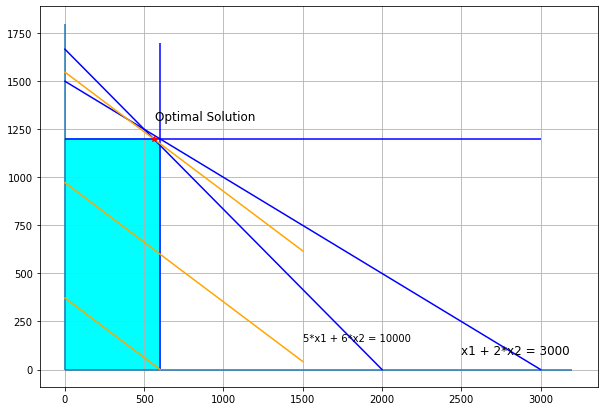

In [29]:
from matplotlib.patches import Polygon

fig, ax = plt.subplots(figsize=(10,7))
ax.grid()
ax.hlines(0, 0, 3200)
ax.vlines(0, 0, 1800)

n = 100
# Draw constraint lines
# x1 + 2*x2 = 3000
ax.plot(np.linspace(0, 3000, n), 3000/2 - 1/2*np.linspace(0, 3000, n), color='b')
ax.text(2500, 80, "x1 + 2*x2 = 3000", size=12)
# 5*x1 + 6*x2 = 10000
ax.plot(np.linspace(0, 2000, n), 10000/6 - 5/6*np.linspace(0, 2000, n), color='b')
ax.text(1500, 150, "5*x1 + 6*x2 = 10000")

ax.hlines(1200, 0, 3000, color='b')
ax.vlines(600, 0, 1700, color='b')

feasible_set = Polygon(np.array([[0,0],
                                 [0, 1200],
                                 [560,1200],
                                 [600, 1166.67],
                                 [600,0]]),
                                color='cyan')
ax.add_patch(feasible_set)

# Draw the objective function
z = 80*600 + 129*0
ax.plot(np.linspace(0,600,n), z/129-80/129*np.linspace(0,600,n), color='orange')

z = 80*600 + 129*600
ax.plot(np.linspace(0,1500,n), z/129-80/129*np.linspace(0,1500,n), color='orange')

z = 80*560 + 129*1200
ax.plot(np.linspace(0,1500,n), z/129-80/129*np.linspace(0,1500,n), color='orange')

ax.plot(560,1200, '*' , color='red')
ax.text(570, 1300, 'Optimal Solution', size=12)
plt.show()

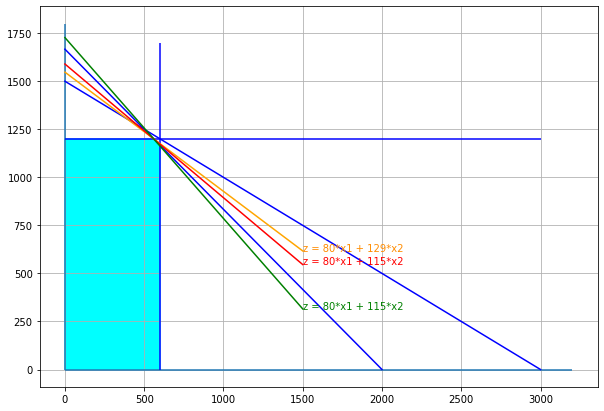

In [52]:
from matplotlib.patches import Polygon

fig, ax = plt.subplots(figsize=(10,7))
ax.grid()
ax.hlines(0, 0, 3200)
ax.vlines(0, 0, 1800)

n = 100
# Draw constraint lines
# x1 + 2*x2 = 3000
ax.plot(np.linspace(0, 3000, n), 3000/2 - 1/2*np.linspace(0, 3000, n), color='b')
# ax.text(2500, 80, "x1 + 2*x2 = 3000", size=12)
# 5*x1 + 6*x2 = 10000
ax.plot(np.linspace(0, 2000, n), 10000/6 - 5/6*np.linspace(0, 2000, n), color='b')
# ax.text(1500, 150, "5*x1 + 6*x2 = 10000")

ax.hlines(1200, 0, 3000, color='b')
ax.vlines(600, 0, 1700, color='b')

feasible_set = Polygon(np.array([[0,0],
                                 [0, 1200],
                                 [560,1200],
                                 [600, 1166.67],
                                 [600,0]]),
                                color='cyan')
ax.add_patch(feasible_set)

# Draw the objective function

z = 80*560 + 129*1200
ax.plot(np.linspace(0,1500,n), z/129-80/129*np.linspace(0,1500,n), color='orange')
ax.text(1500, (z - 80*1500)/129, 'z = 80*x1 + 129*x2', color='darkorange')

z = 80*560 + 115*1200
ax.plot(np.linspace(0,1500,n), z/115-80/115*np.linspace(0,1500,n), color='red')
ax.text(1500, (z - 80*1500)/115, 'z = 80*x1 + 115*x2', color='red')

z = 80*560 + 85*1200
ax.plot(np.linspace(0,1500,n), z/85-80/85*np.linspace(0,1500,n), color='green')
ax.text(1500, (z - 80*1500)/85, 'z = 80*x1 + 115*x2', color='green')

plt.show()